In [4]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [5]:
### data preparation

# load the dataset'
df = pd.read_parquet("scale_1026", engine="auto")

# convert time column to datetime format
df["time"] = pd.to_datetime(df["time"])

# Calculate the time difference using pandas diff() function
df["time_diff"] = df["time"].diff()


# create a column as date column
df["date"] = df["time"].dt.date


# create a column for seconds
df["time_sec"] = df["time_diff"].dt.seconds

# then shifteing time_sec column one row up
df["time_sec"] = df["time_sec"].shift(-1)


# convert time_seconds to hour as numeric_val is tons per hour
df["time_hour"] = df["time_sec"] / (60 * 60)


df = df[["date", "numeric_val", "time_hour"]]

# calculating weighted sum
df = (
    df.assign(weighted_sum=df.numeric_val * df.time_hour)
    .groupby("date", as_index=False)
    .weighted_sum.sum()
)

df['date']=pd.to_datetime(df['date'])
df.set_index("date", inplace=True)

# Filter out the specified date range
df = df.drop(df.loc['2023-05-12':'2023-07-27'].index)

# Replace negative values with zero in 'weighted_sum'
df['weighted_sum'] = df['weighted_sum'].clip(lower=0)

# filter out the specified data range containing zero
df=df.drop(df.loc['2023-05-12':'2023-07-27'].index)

# filter out the first two months assuming machine unstability
df=df.drop(df.loc['2019-10-24':'2020-01-31'].index)

# replace 7 irregular data points with 8th highest value.
df[df['weighted_sum']>570]=570
print(df)

            weighted_sum
date                    
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2023-12-02    114.049422
2023-12-03      0.000000
2023-12-04    226.893157
2023-12-05    390.659238
2023-12-06    425.322937

[1317 rows x 1 columns]


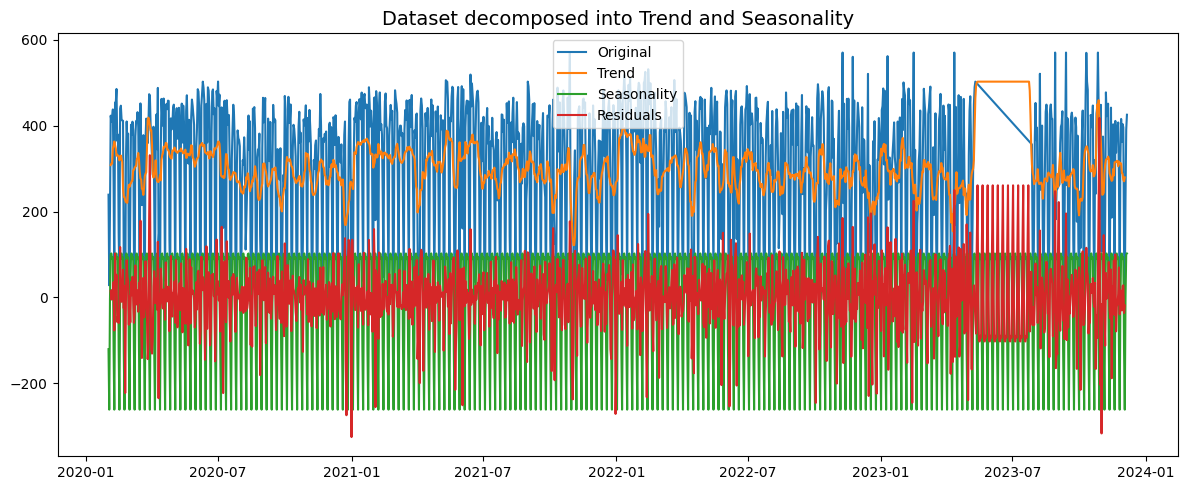

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Set the frequency of the DateTime index
df_freq = df.asfreq('D')
df_fill = df_freq.ffill()  # Forward-fill method, alternatively use backward-fill or interpolate

decomposition = seasonal_decompose(df_fill)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df, label='Original')
ax.plot(trend, label='Trend')
ax.plot(seasonal, label='Seasonality')
ax.plot(residual, label='Residuals')
ax.legend(loc='upper center')
ax.set_title('Dataset decomposed into Trend and Seasonality', fontsize= 14)
plt.tight_layout()
# Save the plot as a PDF
plt.savefig('decompostion.png')

plt.show()

## Construction of the frequency spectrum from the time-domain

- The frequency spectrum can be used to determine whether the time-series contains any seasonal components, at which frequencies these seasonal components occur and how we can separate them.

- A time-series can have multiple seasonal components (with different frequencies, amplitudes, etc) and mixed together in the total signal.

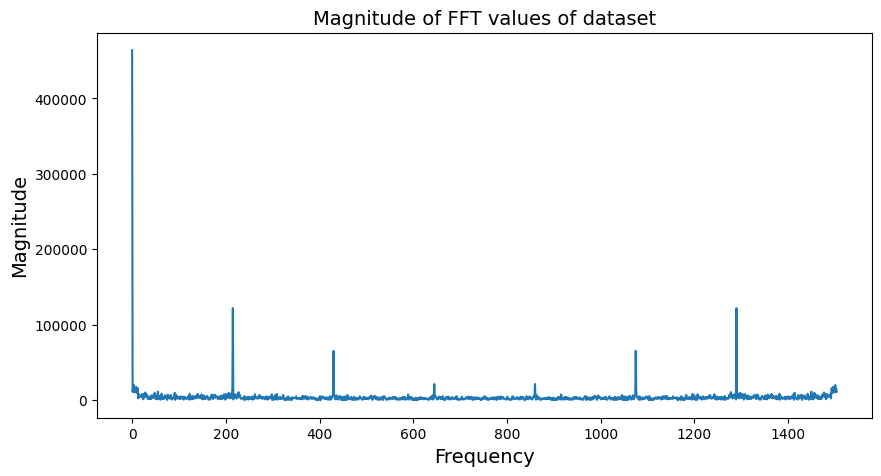

In [10]:

# Extract y-values from the DataFrame and storage them in 'yvalues' array
yvalues = df_fill['weighted_sum']

# Perform FFT
fft_y = np.fft.fft(yvalues)

# Compute the positive magnitudes of the FFT results
fft_magnitude = np.abs(fft_y)

# Plot the magnitude of FFT results
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(fft_magnitude)
ax.set_title('Magnitude of FFT values of dataset', fontsize=14)
ax.set_xlabel('Frequency', fontsize=14)
ax.set_ylabel('Magnitude', fontsize=14)
plt.savefig(' Magnitude')
plt.show()

The first value in the FFT result i.e index 0 represents the average value of the signal. As we know, the period is inversely proportional to the frequency i.e T = 1 / f. So, high frequencies f correspond with small periods T and low frequencies with large period values. The lower we go in frequency, the larger the period T becomes. 

In fact, a frequency f of zero corresponds with a period T of infinite. So if the result of the FFT contains a large peak at zero frequency, this means that we have a component in the signal with an infinite period, i.e. a component which is simply a flat line. This means that we have a bias offset in the signal and the average y-value in our signal is not zero. This is called the DC component of the signal.

#### More interpretable frequency spectrum 
To understand periodic patterns, filter out noise 

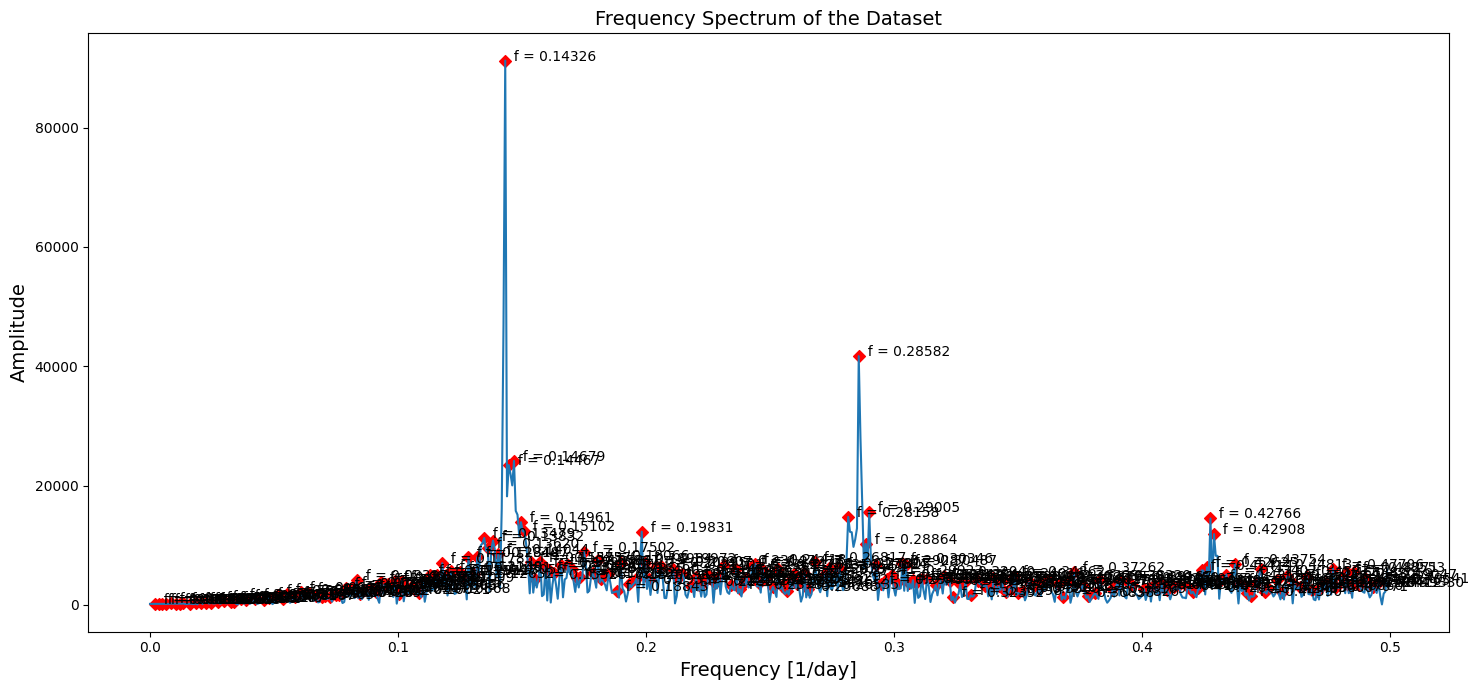

In [26]:

from scipy.signal import find_peaks, savgol_filter

# Extract y-values from the DataFrame
yvalues = df['weighted_sum'].values

# Detrend or subtract the average value from data using Savitzky-Golay filter in order to remove the large peak at zero frequency.

yvalues_trend = savgol_filter(yvalues, window_length=7, polyorder=1) # smoothed yvalues, representing the trend component of data.
yvalues_detrended = yvalues - yvalues_trend # detrended original data, linear trend removed,


fft_y_ = np.fft.fft(yvalues_detrended) # Perform FFT on the detrended data. take absolute to make neg. amplitude positive and
fft_y = np.abs(fft_y_[:len(fft_y_) // 2]) # take into account the first half of frequency spectrum as second half is mirror image.(euler's formula)

fft_x_ = np.fft.fftfreq(len(yvalues_detrended)) # returns an array of frequency values corresponding to the FFT output
fft_x = fft_x_[:len(fft_x_) // 2]

# Detect peaks in the FFT magnitudes
indices_peaks, _ = find_peaks(fft_y, height=20)

# Plot the magnitude of FFT results and detected peaks
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(fft_x, fft_y)
ax.scatter(fft_x[indices_peaks], fft_y[indices_peaks], color='red', marker='D')
ax.set_title('Frequency Spectrum of the Dataset', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_xlabel('Frequency [1/day]', fontsize=14)

for idx in indices_peaks:
    x, y = fft_x[idx], fft_y[idx]
    text = "  f = {:.5f}".format(x, y)
    ax.annotate(text, (x, y))

plt.tight_layout()
plt.savefig('frequency')
plt.show()


here, we can see the absolute, positive frequency values of the detrended time-series.
This frequency spectrum looks much better and more like a frequency spectrum we are used to. There are several peaks in the frequency spectrum at f = 0.14326, 0.285821, and 0.42766. These frequencies correspond with a period ( T = 1 / f) of 6.99, 3.5, and 2.33 days. Meaning there is a seasonal components which occurs every week, half of a week.

In [28]:
f= 0.14326
T=1/f
T

6.980315510261064

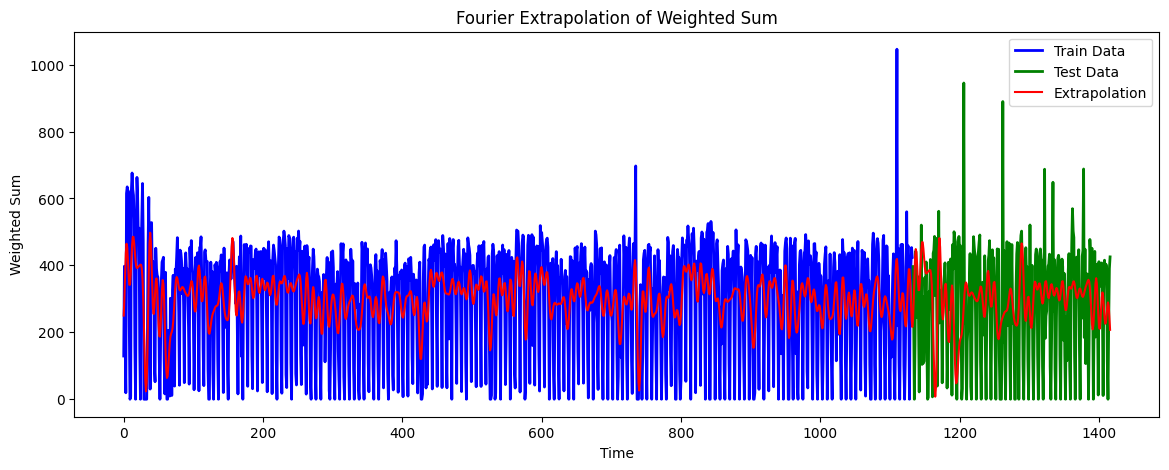

RMSE for the test set: 191.43891406565706


In [18]:
import numpy as np
from numpy import fft
import pandas as pd

def fourierExtrapolation(x, n_predict, n_harm):
    n = x.size
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)  # find linear trend in x
    x_notrend = x - p[0] * t  # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)  # frequencies
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i])) # sort indexes by frequency, lower -> higher

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n  # amplitude
        phase = np.angle(x_freqdom[i])  # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

def main():
    # Load dataset
    x = df["weighted_sum"].values  # Use the 'weighted_sum' column
    
    # Train-test split
    train_size = int(len(df)*0.80)
    train_data = x[:train_size]
    test_data = x[train_size:]

    # Number of points to predict
    n_predict = len(test_data)  # Predict the length of the test data
    n_harm = 140               # Number of harmonics;
    extrapolation = fourierExtrapolation(train_data, n_predict, n_harm)

    # Plot the original, train, and extrapolated data
    plt.figure(figsize=(14,5))
    plt.plot(np.arange(0, train_data.size), train_data, 'b', label='Train Data', linewidth=2)
    plt.plot(np.arange(train_data.size, train_data.size + n_predict), test_data, 'g', label='Test Data', linewidth=2)
    plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label='Extrapolation')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Weighted Sum')
    plt.title('Fourier Extrapolation of Weighted Sum')
    plt.show()
    
    # Calculate RMSE for the entire test set
    rmse = np.sqrt(mean_squared_error(test_data, extrapolation[train_size:train_size + n_predict]))
    print(f"RMSE for the test set: {rmse}")


main()


### Reconstructing the Time-domain using np.fft.ifft()


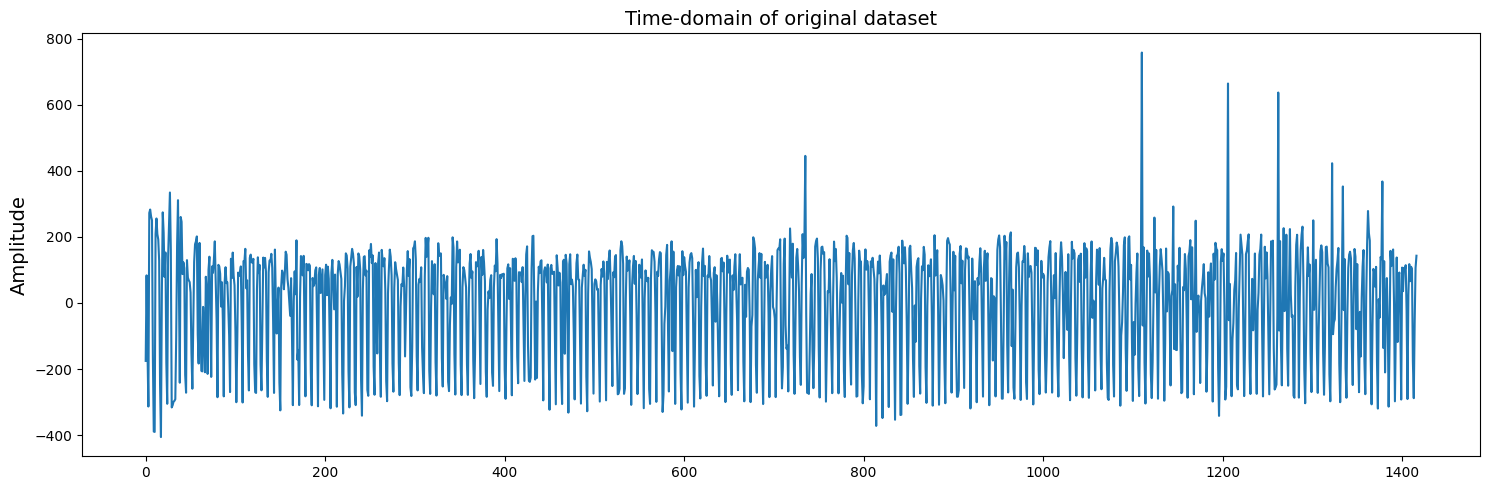

In [362]:
fft_y_  = np.fft.fft(yvalues_detrended)
inverse_fft = np.fft.ifft(fft_y_)

# Convert to real values (discard the imaginary part)
inverse_fft_real = np.real(inverse_fft)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(inverse_fft_real, label='The inverse of the freq. spectrum')
ax.set_ylabel('Amplitude', fontsize=14)
ax.set_title('Time-domain of original dataset', fontsize=14)
plt.tight_layout()
plt.show()



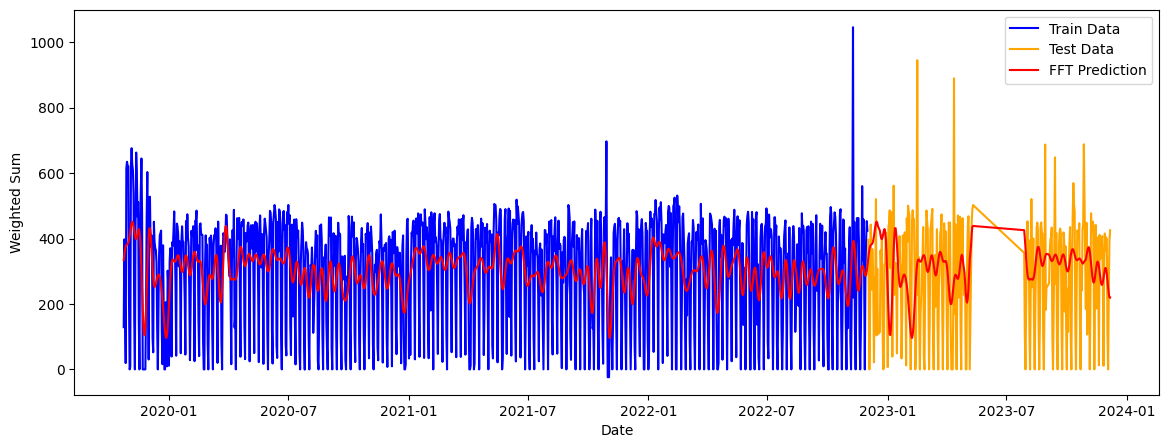

RMSE: 189.39724189777797


In [550]:
import numpy as np
from numpy.fft import fft, fftfreq, ifft

# data split 
split_point = int(0.8 * len(df))
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

# Perform FFT on the training data
fft_y_ = fft(df_train['weighted_sum'].values)

# Keep only the top n_freqs frequencies (can be adjusted)
n_freqs = 100
fft_filtered = np.zeros_like(fft_y_)
fft_filtered[:n_freqs] = fft_y_[:n_freqs]
fft_filtered[-n_freqs:] = fft_y_[-n_freqs:]

# Perform inverse FFT to get the predicted values
predicted_values_train = np.real(ifft(fft_filtered))

# Extrapolate the predicted values for the test period
extrapolation = np.real(ifft(fft_filtered))[:len(df_test)]
predicted_values = np.concatenate([predicted_values_train, extrapolation])

# Convert predicted values to DataFrame
pred_df = pd.DataFrame(data={'date': df.index, 'weighted_sum': predicted_values})
pred_df.set_index('date', inplace=True)

# Plot the results
plt.figure(figsize=(14, 5))

# Plotting train and test data without missing data gaps
plt.plot(df_train.index, df_train['weighted_sum'], label='Train Data', color='blue')
plt.plot(df_test.index, df_test['weighted_sum'], label='Test Data', color='orange')
plt.plot(pred_df.index, pred_df['weighted_sum'], label='FFT Prediction', color='red')

plt.xlabel('Date')
plt.ylabel('Weighted Sum')
plt.legend()
plt.show()

# Calculate RMSE on the test data
actual_values_test = df_test['weighted_sum'].values
predicted_values_test = predicted_values[len(df_train):]

rmse_value = np.sqrt(mean_squared_error(actual_values_test, predicted_values_test))
print(f"RMSE: {rmse_value}")


            weighted_sum  trend_linear
date                                  
2019-10-24    129.124763    329.045022
2019-10-25    397.525094    328.984851
2019-10-26    179.953536    328.924680
2019-10-27     19.276294    328.864508
2019-10-28    614.867925    328.804337
...                  ...           ...
2023-12-02    114.049422    238.788224
2023-12-03      0.000000    238.728053
2023-12-04    226.893157    238.667881
2023-12-05    390.659238    238.607710
2023-12-06    425.322937    238.547539

[1491 rows x 2 columns]


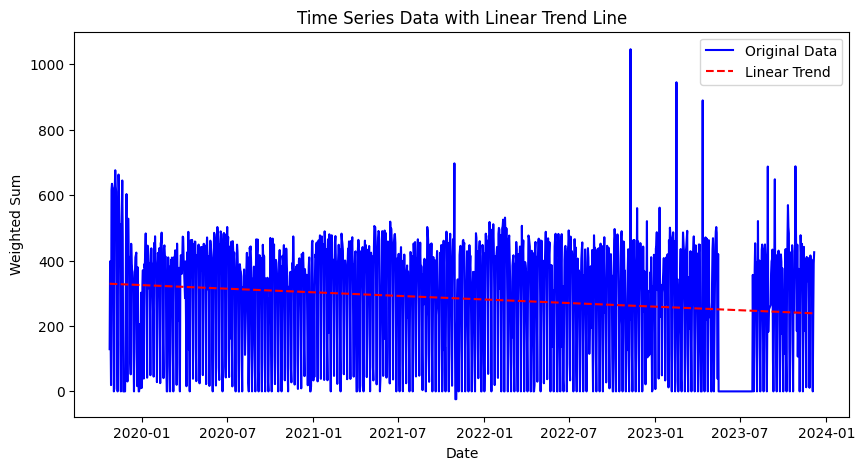

In [6]:
# Prepare the data for linear regression

df = pd.read_csv('weighted_sum.csv')

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df = df.set_index('date')

# Convert the date index to numerical format (ordinal)
df['date_ordinal'] = df.index.map(pd.Timestamp.toordinal)

# Prepare the data for linear regression
X = df[['date_ordinal']]  # Features (independent variable)
y = df['weighted_sum']    # Target (dependent variable)



from sklearn.linear_model import LinearRegression
# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Predict the trend line
df['trend_linear'] = linear_model.predict(X)
print(df[['weighted_sum', 'trend_linear']])
# Plot the original data and the trend line
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['weighted_sum'], label='Original Data', color='blue')
plt.plot(df.index, df['trend_linear'], label='Linear Trend', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Weighted Sum')
plt.title('Time Series Data with Linear Trend Line')
plt.legend()
plt.show()

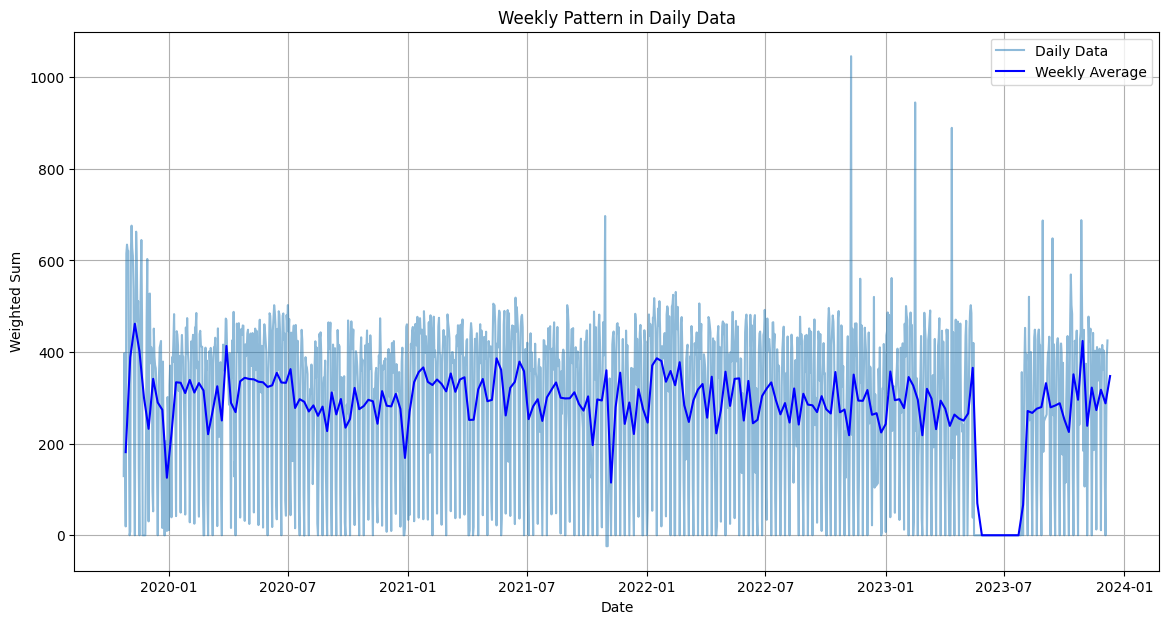

In [19]:
# Resample to weekly frequency and calculate the mean
weekly_data = df.resample('W').mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['weighted_sum'], label='Daily Data',  alpha=0.5)
plt.plot(weekly_data.index, weekly_data['weighted_sum'], label='Weekly Average', color='blue')
plt.xlabel('Date')
plt.ylabel('Weighted Sum')
plt.title('Weekly Pattern in Daily Data')
plt.legend()
plt.grid(True)
plt.show()